In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import LinearSVC as SVM
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, KFold
from scipy import stats

[1] Используя make_blobs с любым random_state, сгенерировать датасет df1, в котором есть три класса с размером каждого класса 1000 и четыре количественных (недискретных) признака.

In [ ]:
# x, y = make_blobs(n_samples=3*1000, n_features=4, random_state=13)
x, y = make_blobs(n_samples=3*1000, n_features=4, random_state=73)

df1 = pd.DataFrame(x)
df1['target'] = y
df1 = df1.sort_values(by='target').reset_index(drop=True)

display(df1)

0         1         2         3  target
0     2.789334  1.129934  0.602402  2.634510       0
1     3.736677  1.847644  2.217292  3.661128       0
2     2.228320 -0.578542 -0.229807  2.307159       0
3     2.798341  0.809968  0.591163  1.469652       0
4     3.181943  1.854876  2.154310  3.291179       0
...        ...       ...       ...       ...     ...
2995  5.419334 -2.990423 -2.101210  2.145473       2
2996  6.284612 -2.217566 -1.686207  1.300457       2
2997  6.451068 -4.947609 -0.918217  2.147011       2
2998  4.250860 -2.975947 -1.402766  1.403938       2
2999  6.533742 -3.099444 -1.468786  2.314943       2

[3000 rows x 5 columns]

[2] Не забываем повторять шаги с задания 1
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

In [ ]:
feature_columns = [col for col in df1.columns if col not in ['target', 'id']]
display(df1.describe())

statistics = {"Shape": f"({df1.shape[0]}, {df1.shape[1]})",
              "Features": len(feature_columns),
              "Classes": df1['target'].nunique(),
              "Entries": f"{df1['target'].value_counts().reset_index()['count'].tolist()}",
              # "Missing": f"{[str((df1[i].isnull().sum() / len(df1[i])) * 100) for i in feature_columns]}",
              "Missing": f'{df1.isnull().mean().sum() * 100} %'}

df1_statistics = pd.DataFrame(statistics, index=[0])
display(df1_statistics)

0            1            2            3       target
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000
mean      2.710492    -2.921393    -2.288021     1.853816     1.000000
std       2.525914     2.891887     2.440499     1.022529     0.816633
min      -3.211383    -9.224360    -8.165646    -1.996355     0.000000
25%       0.427237    -5.270773    -4.552628     1.168406     0.000000
50%       2.890609    -3.732411    -1.917730     1.876423     1.000000
75%       4.866865     0.064383    -0.271597     2.547522     2.000000
max       8.654240     3.696568     3.064581     5.442199     2.000000

Shape  Features  Classes             Entries Missing
0  (3000, 5)         4        3  [1000, 1000, 1000]   0.0 %

In [ ]:
correlation_matrix = df1.corr()

print("Dataset correlation matrix:")
display(correlation_matrix)

for class_value in df1['target'].unique():
    class_df = df1[df1['target'] == class_value].drop(columns=['target'])
    corr_matrix_class = class_df.corr()

    print(f'\nCorrelation matrix for class {class_value}:')
    display(corr_matrix_class)

Dataset correlation matrix:


0         1         2         3    target
0       1.000000  0.295270  0.547938  0.164262  0.415019
1       0.295270  1.000000  0.807606  0.285473 -0.640251
2       0.547938  0.807606  1.000000  0.295913 -0.353870
3       0.164262  0.285473  0.295913  1.000000 -0.142575
target  0.415019 -0.640251 -0.353870 -0.142575  1.000000


Correlation matrix for class 0:


0         1         2         3
0  1.000000 -0.019043  0.018095  0.023155
1 -0.019043  1.000000  0.060659 -0.009681
2  0.018095  0.060659  1.000000  0.031099
3  0.023155 -0.009681  0.031099  1.000000


Correlation matrix for class 1:


0         1         2         3
0  1.000000  0.022637  0.051148 -0.017287
1  0.022637  1.000000  0.046136  0.026609
2  0.051148  0.046136  1.000000  0.036939
3 -0.017287  0.026609  0.036939  1.000000


Correlation matrix for class 2:


0         1         2         3
0  1.000000 -0.016468  0.027249 -0.005848
1 -0.016468  1.000000 -0.008139  0.049705
2  0.027249 -0.008139  1.000000  0.055984
3 -0.005848  0.049705  0.055984  1.000000

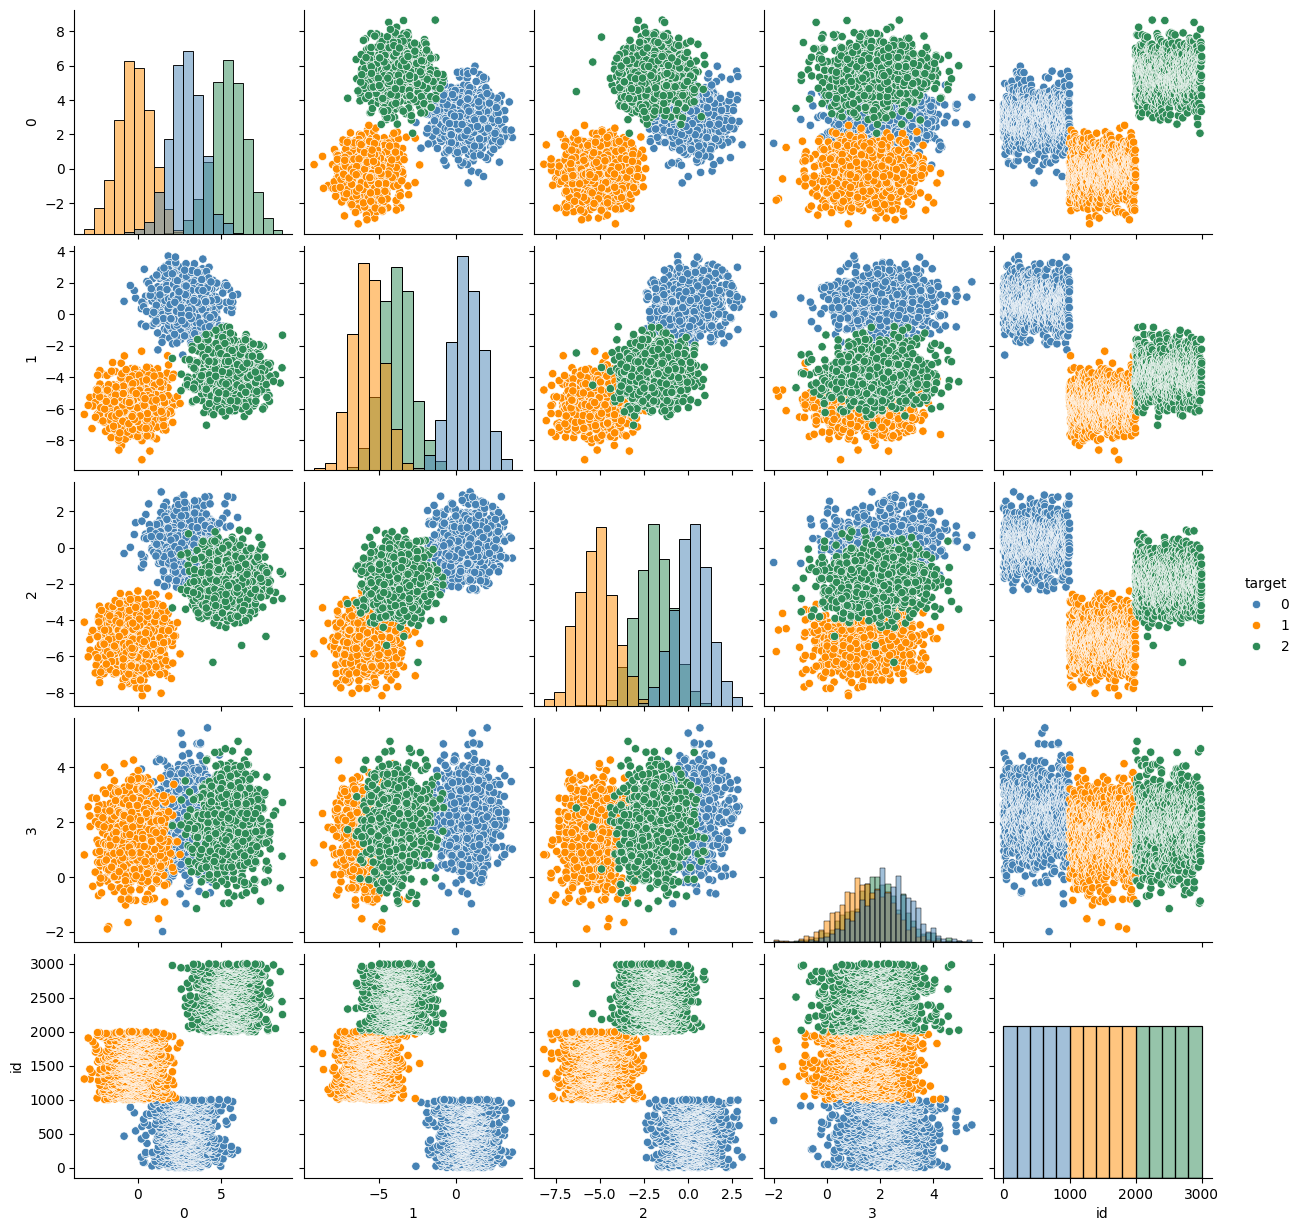

In [ ]:
df1['id'] = df1.index

# sns.pairplot(df1, hue='target', palette=['steelblue', 'darkorange', 'seagreen'])
sns.pairplot(df1, hue='target', palette=['steelblue', 'darkorange', 'seagreen'], diag_kind='hist')
plt.show()

[3] На основе созданного в пункте [1] датасета сгенерировать отдельные
дополнительные датасеты (df2, df5, df10…), в которых объекты одного класса
повторены 2 раза, 5 раз, 10 раз, 20 раз, 50 раз, 100 раз, 1000 раз, 10k раз, а
количество объектов в остальных классов неизменно.

In [ ]:
def repeat_entries(df, target_class, n_times):
    target_df = df[df['target'] == target_class]
    non_target_df = df[df['target'] != target_class]

    repeated_df = pd.concat([target_df] * n_times, ignore_index=True)
    return pd.concat([non_target_df, repeated_df], ignore_index=True)

df_multipliers = [1, 2, 5, 10, 20, 50, 100, 1000, 10000]
repeat_df_dict = {}

print("Number of entries for each class in:")
for i in df_multipliers:
    repeat_df_dict[i] = repeat_entries(df1, 0, i)
    print(f"df{i} - {repeat_df_dict[i]['target'].value_counts().reset_index()['count'].tolist()}")


Number of entries for each class in:
df1 - [1000, 1000, 1000]
df2 - [2000, 1000, 1000]
df5 - [5000, 1000, 1000]
df10 - [10000, 1000, 1000]
df20 - [20000, 1000, 1000]
df50 - [50000, 1000, 1000]
df100 - [100000, 1000, 1000]
df1000 - [1000000, 1000, 1000]
df10000 - [10000000, 1000, 1000]


[4] Выбрать пару классов (включая класс с повторенными объектами) и пару
количественных признаков.

Используя метод LDA (линейный дискриминантный анализ), для каждого из
датасетов df1, df2, df5, df10, df20, df50, df100, df1000, df10k, построить решающую
функцию алгоритма, разграниченные решающей функцией зоны и отдельные
объекты классов.

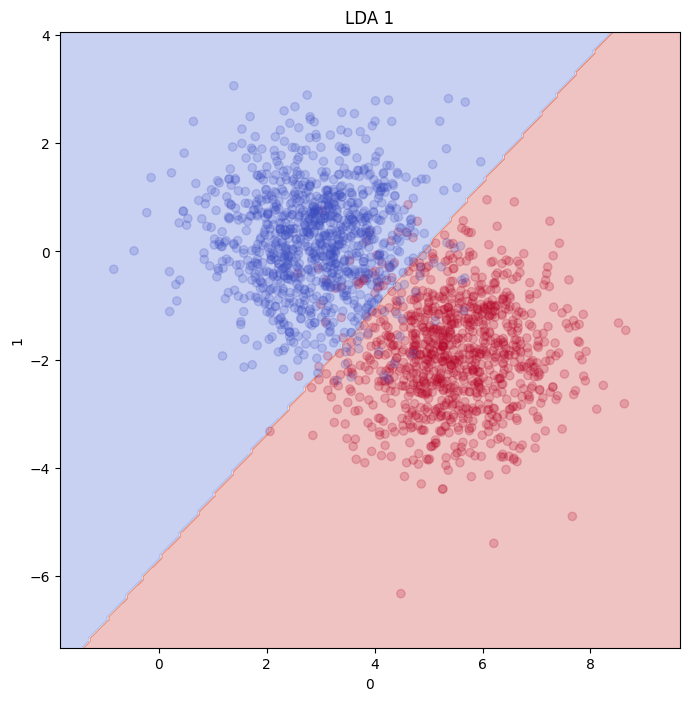

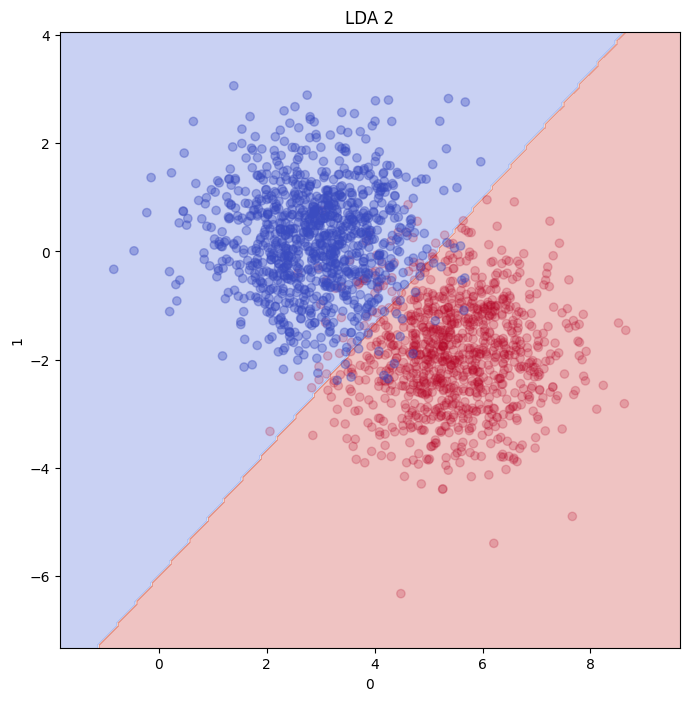

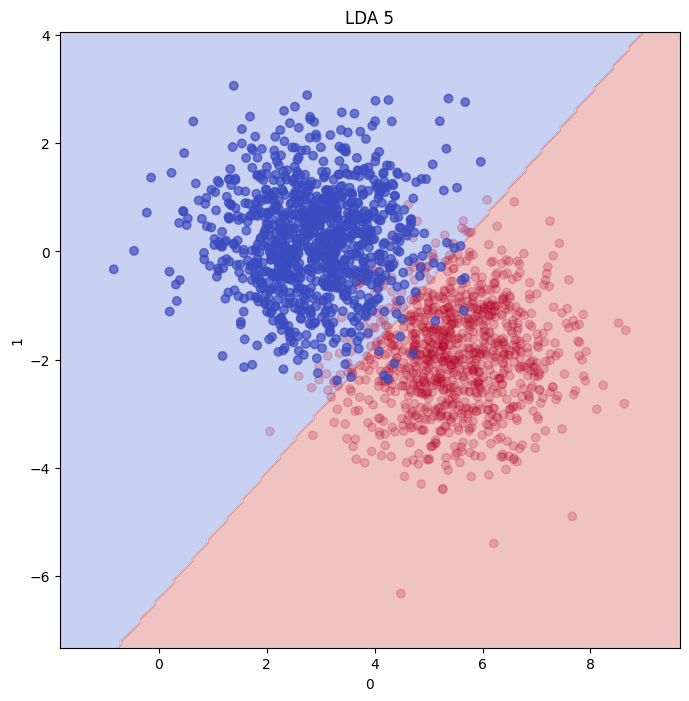

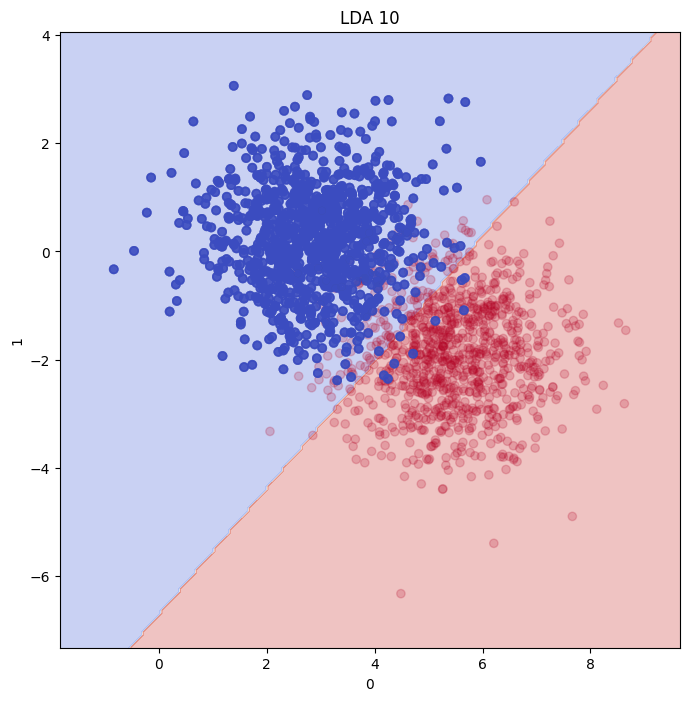

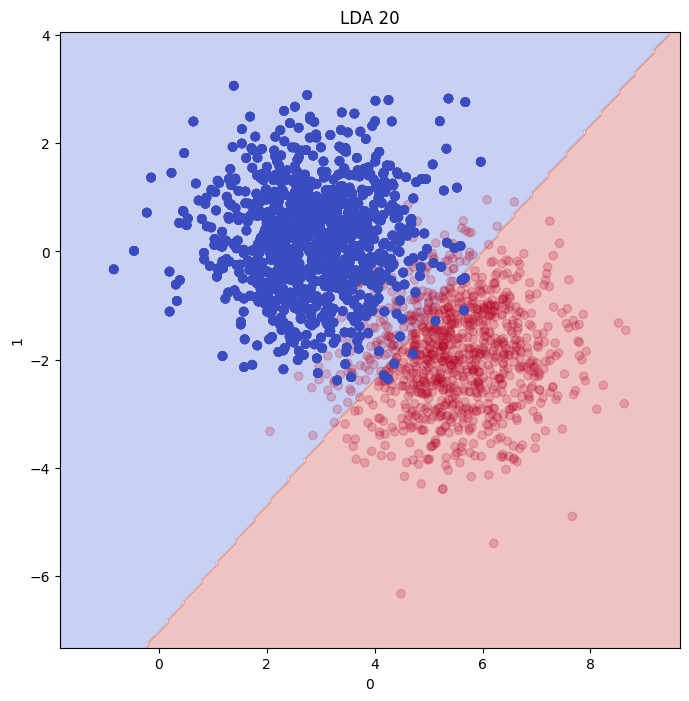

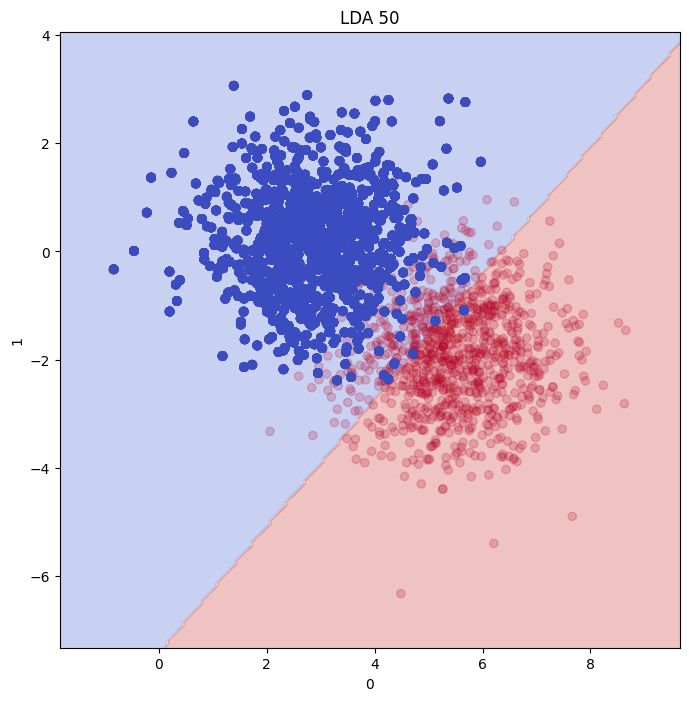

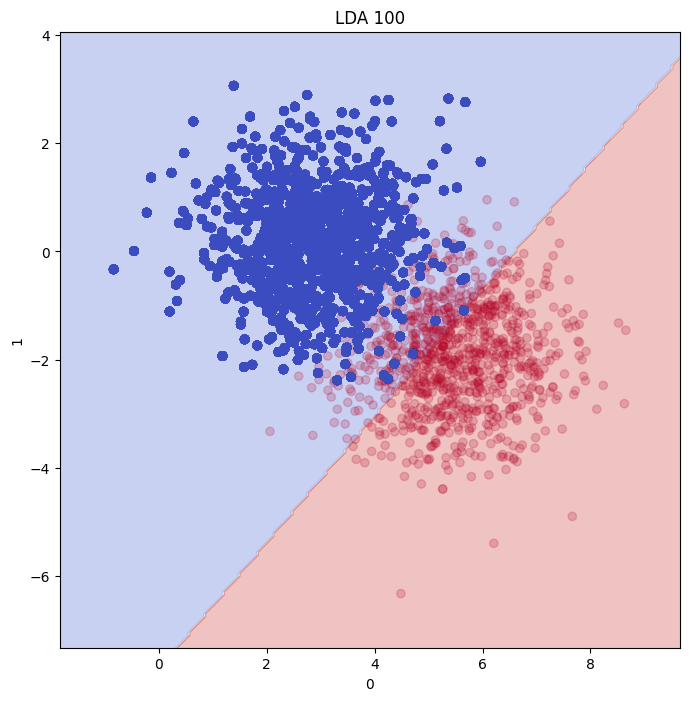

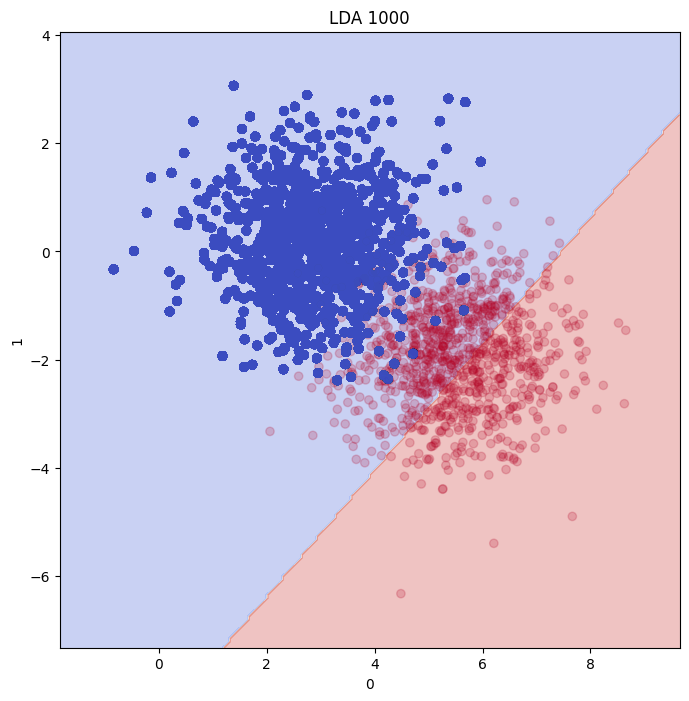

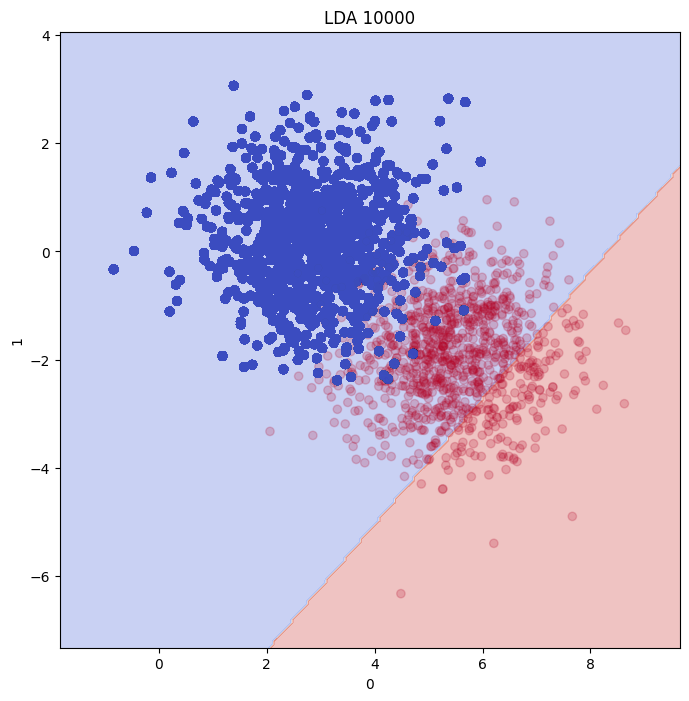

In [ ]:
def extract_classes(df):
    df = df[df['target'].isin([0, 2])]
    return df[[0, 2, 'target']]


classes = [0, 2]
results = {}
lda_trained = {}


def show_lda(df, lda, m):
    filtered_df = extract_classes(df)

    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])

    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    lda.fit(x, y)
    lda_trained[m] = lda

    res = lda.predict(np.c_[xx.ravel(), yy.ravel()])
    res = res.reshape(xx.shape)
    results[m] = res

    plt.contourf(xx, yy, res, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.title(f"LDA {m}")
    plt.xlabel("0")
    plt.ylabel("1")


for m in df_multipliers:
    plt.figure(figsize=(8, 8))
    plt.tight_layout()
    show_lda(repeat_df_dict[m], LDA(), m)
    plt.show()

[5] Повторить пункт [4] для алгоритма SVM.

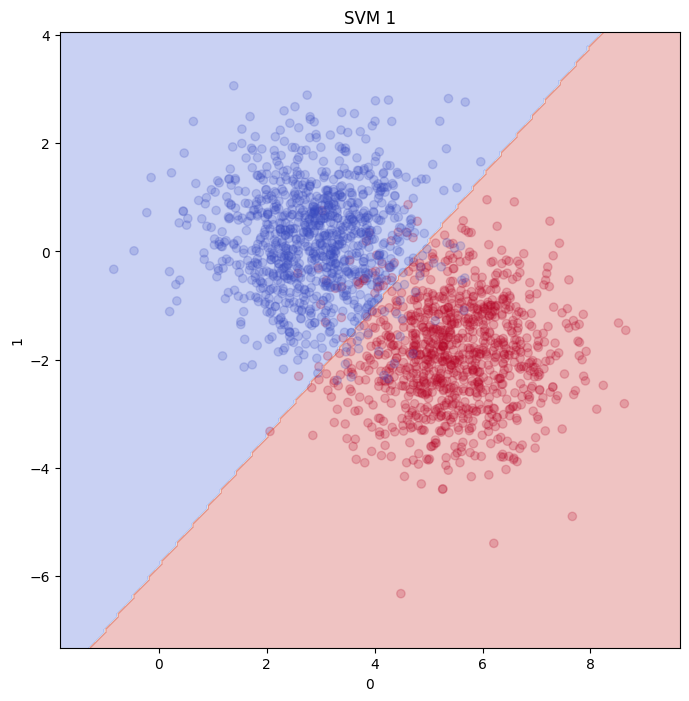

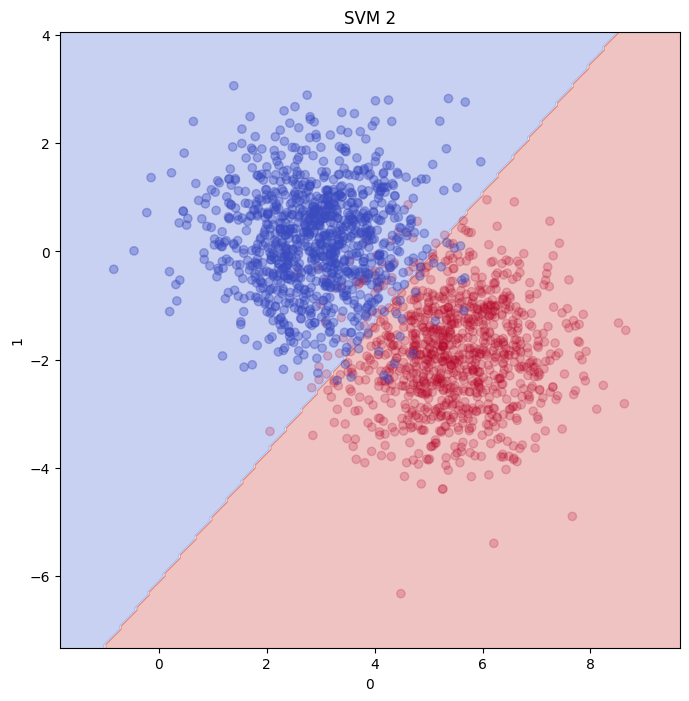

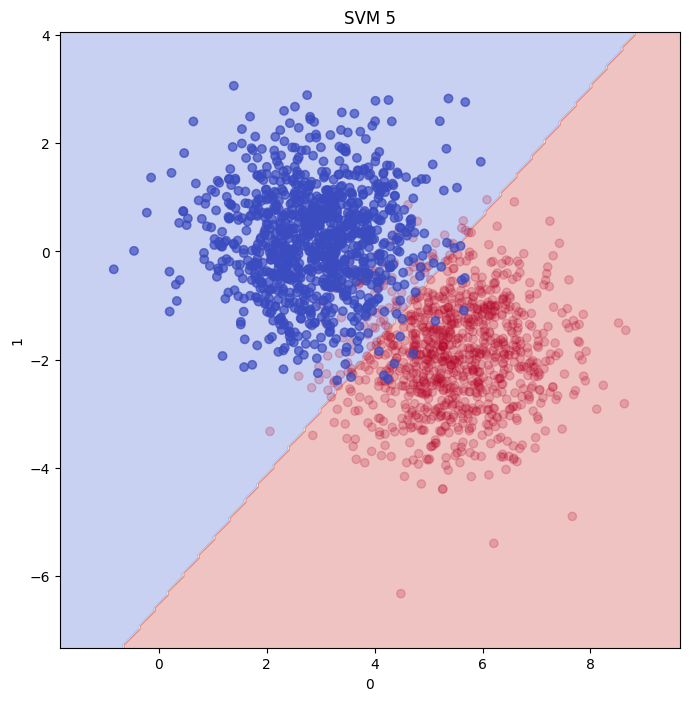

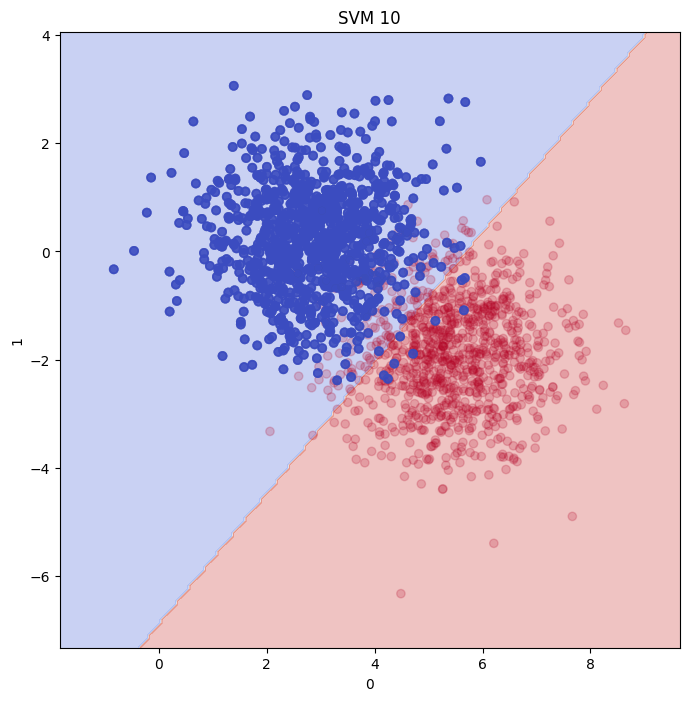

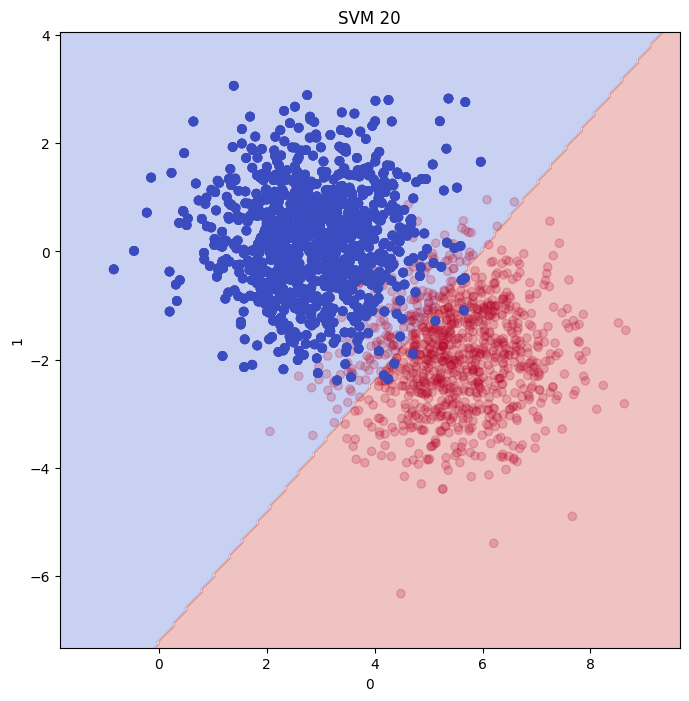

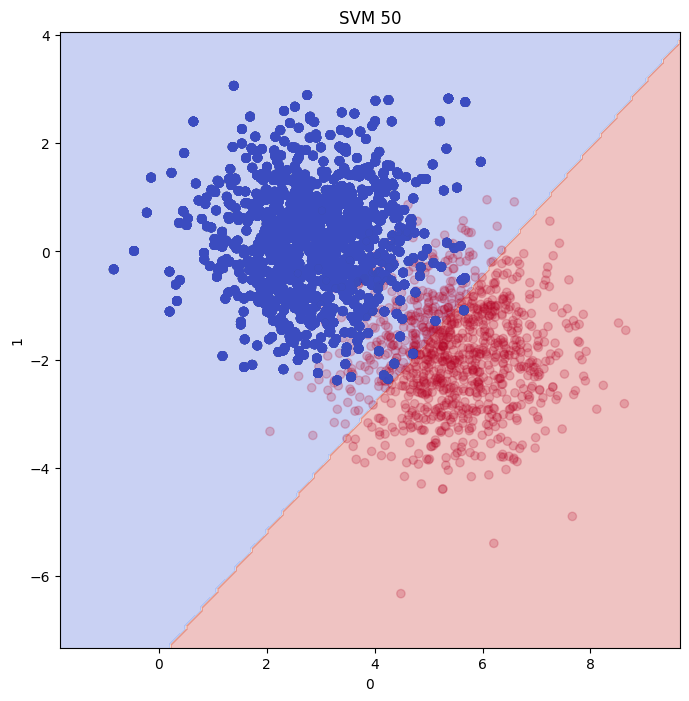

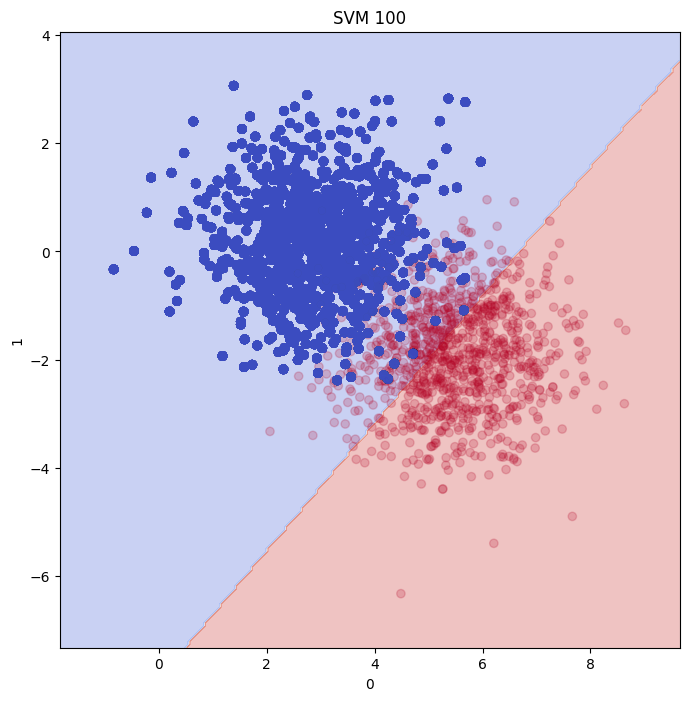

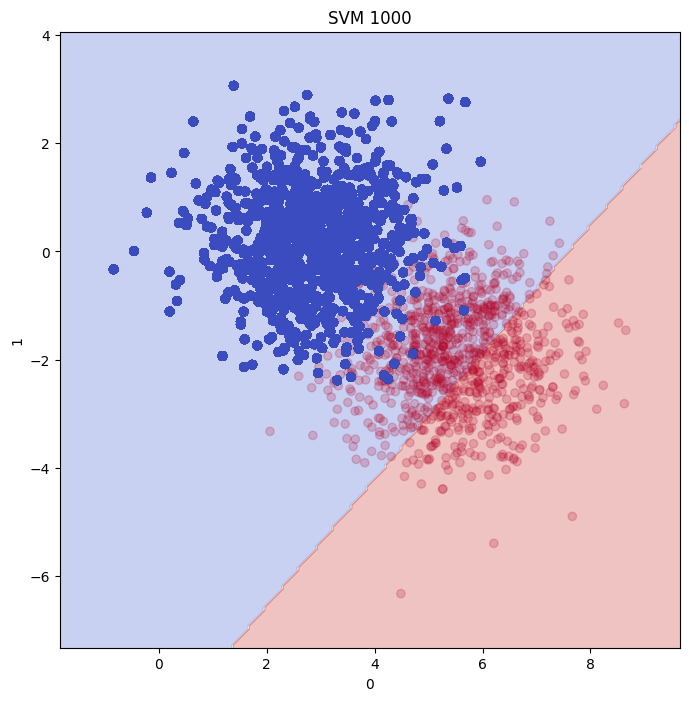

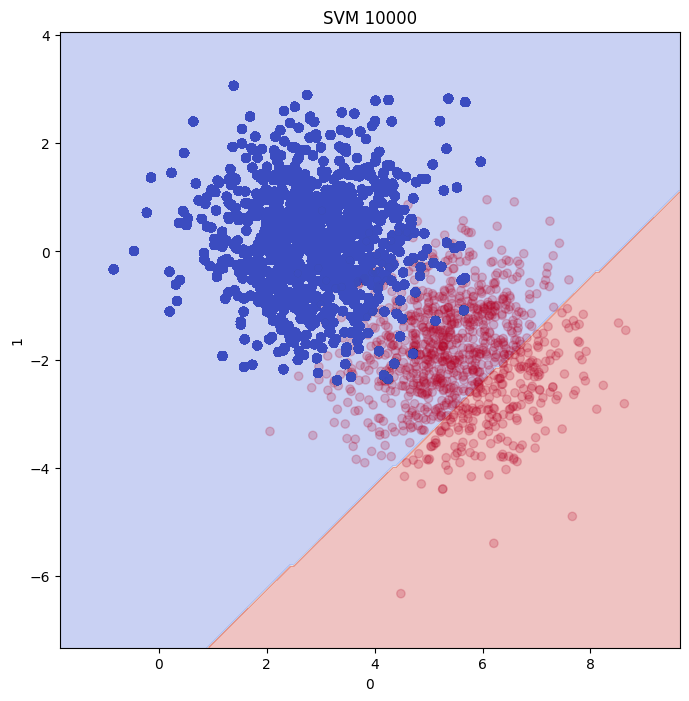

In [ ]:
svm_results = {}


def show_svm(df, svm, m):
    filtered_df = extract_classes(df)

    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])

    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    svm.fit(x, y)
    res = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    res = res.reshape(xx.shape)
    svm_results[m] = res

    plt.contourf(xx, yy, res, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.2, cmap=plt.cm.coolwarm)
    plt.title(f"SVM {m}")
    plt.xlabel("0")
    plt.ylabel("1")


for m in df_multipliers:
    plt.figure(figsize=(8, 8))
    show_svm(repeat_df_dict[m], SVM(), m)
    plt.show()

[6] Для каждого из датасетов df1, df2, df5, df10, df20, df50, df100, df1000, df10k из
пункта [4] восстановить в таблицу координаты следующих точек:
- центр отрезка, соединяющего центры масс выбранных классов
- общий центр масс выбранных классов
- точку пересечения решающей функции и отрезка, соединяющего центры масс
выбранных классов.

В виде графиков визуализировать зависимости между количеством повторов в
классе с повторенными объектами и координатами найденных точек.

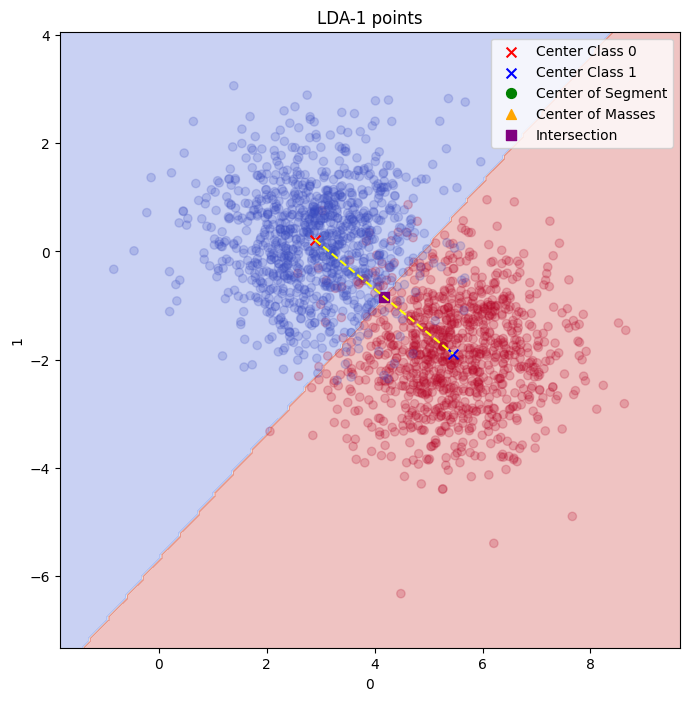

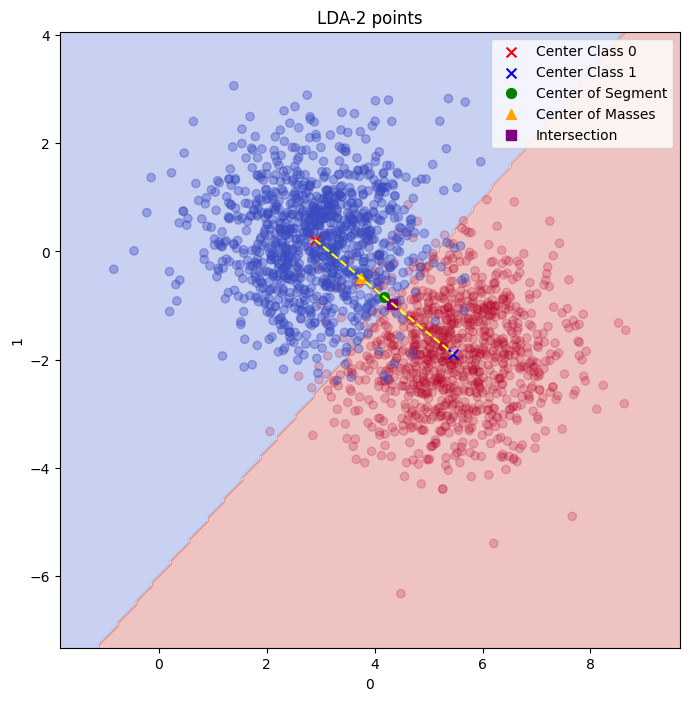

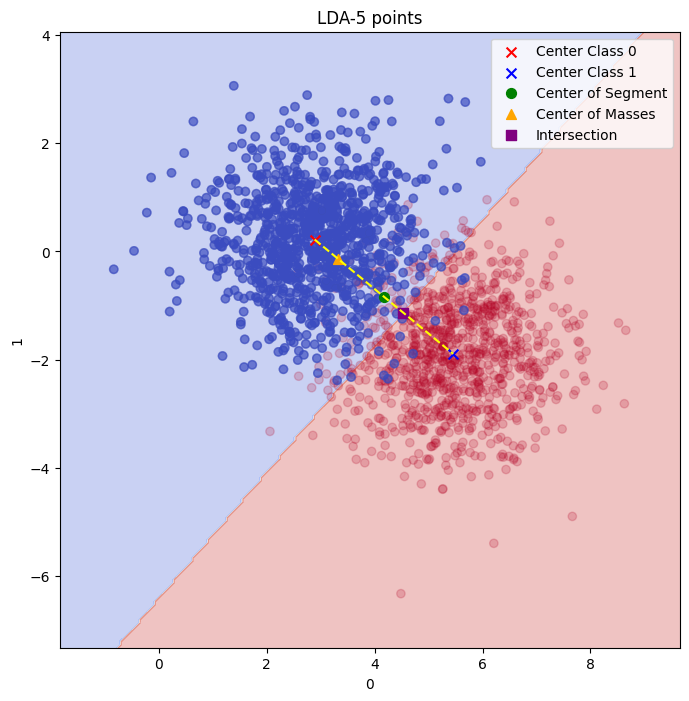

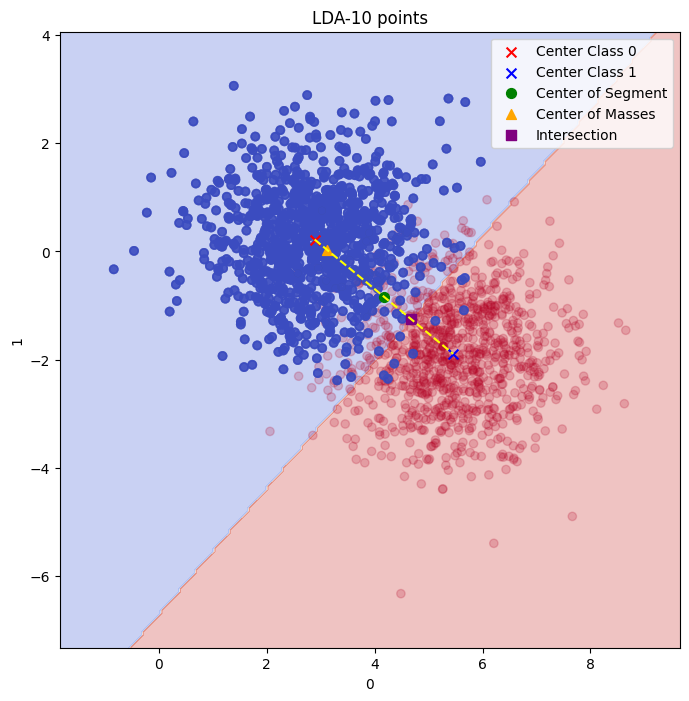

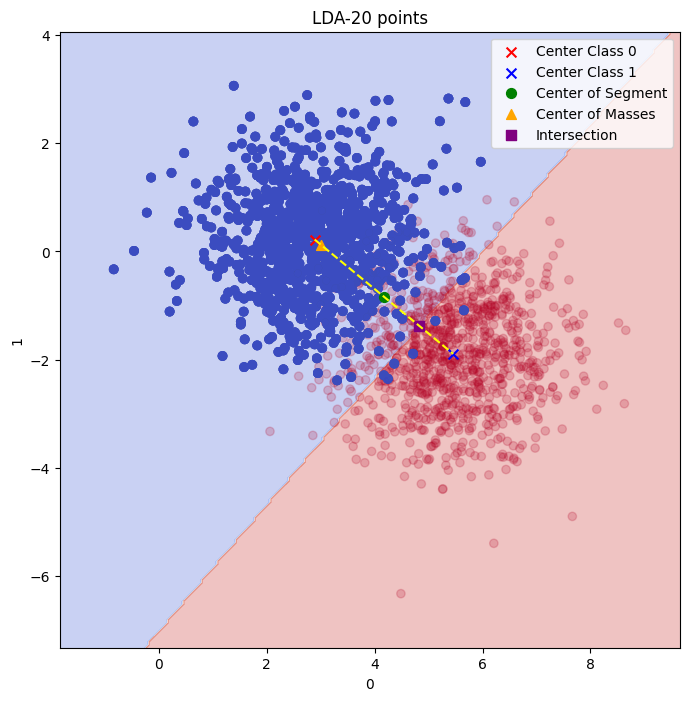

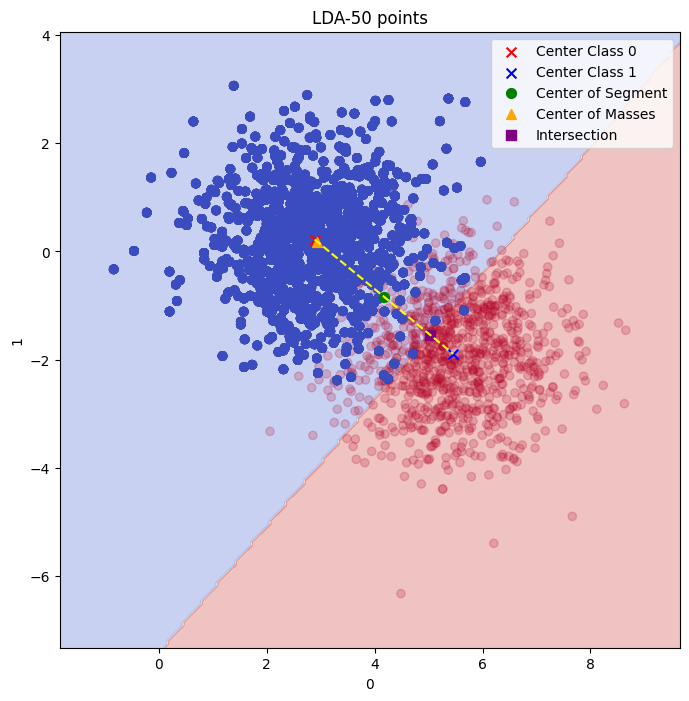

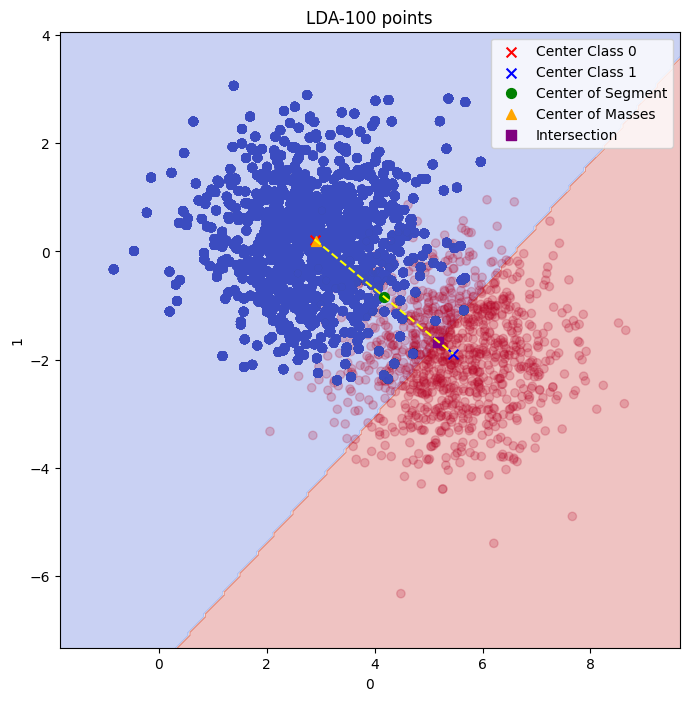

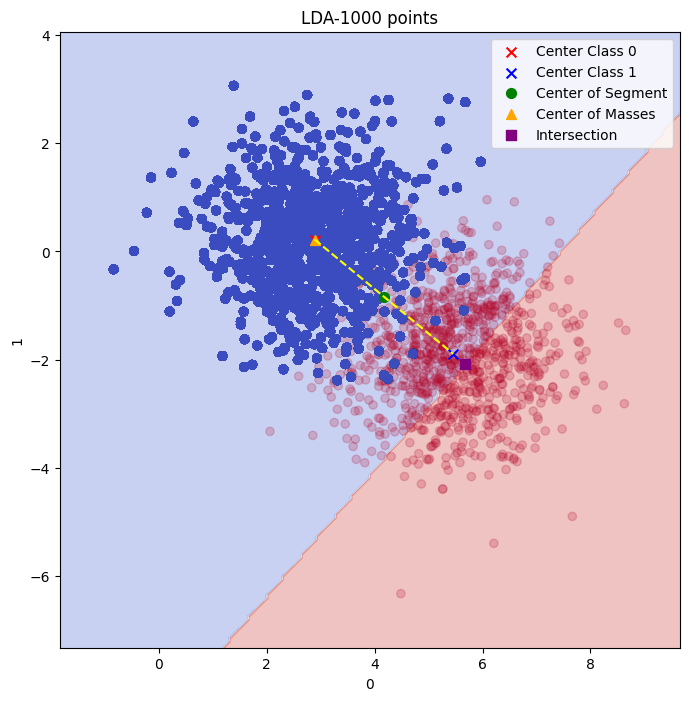

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


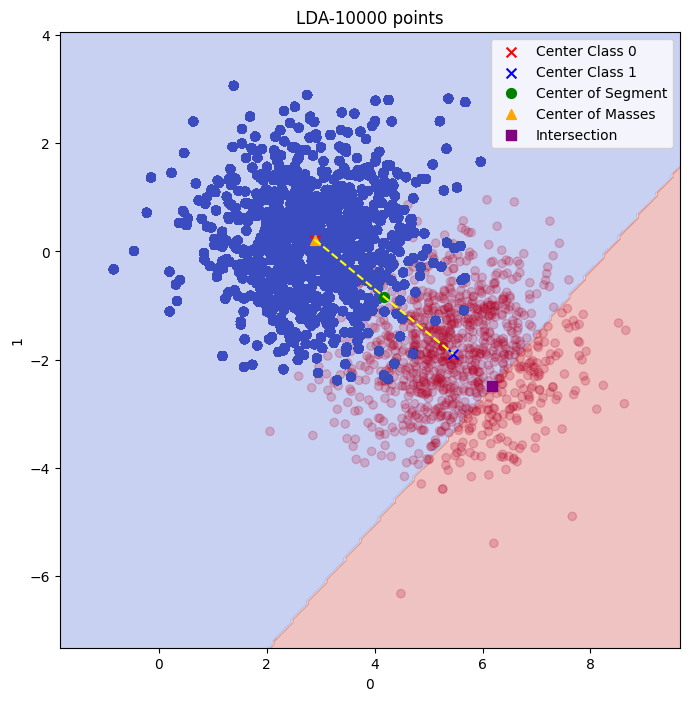

In [ ]:
class_centers = {}
global_centers = {}
segment_centers = {}
intersections = {}


def compute_points(df, res, lda, m):
    filtered_df = extract_classes(df)

    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])

    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

    df_class_0 = filtered_df[filtered_df['target'] == 0]
    df_class_1 = filtered_df[filtered_df['target'] == 2]

    center_class_0 = df_class_0[[0, 2]].mean().values
    center_class_1 = df_class_1[[0, 2]].mean().values
    class_centers[m] = [center_class_0, center_class_1]

    center_of_segment = (center_class_0 + center_class_1) / 2
    segment_centers[m] = center_of_segment

    both_classes = pd.concat([df_class_0, df_class_1], ignore_index=True)
    center_both_classes = both_classes[[0,2]].mean().values
    global_centers[m] = center_both_classes

    w = lda.coef_[0]
    b = lda.intercept_[0]

    segment_vector = center_class_1 - center_class_0
    t = -(np.dot(w, center_class_0) + b) / np.dot(w, segment_vector)

    intersection_point = center_class_0 + t * segment_vector
    intersections[m] = intersection_point

    plt.figure(figsize=(8, 8))

    plt.contourf(xx, yy, res, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.2, cmap=plt.cm.coolwarm)

    plt.plot([center_class_0[0], center_class_1[0]], [center_class_0[1], center_class_1[1]], color='yellow', linestyle='--')
    plt.scatter(center_class_0[0], center_class_0[1], color='red', marker='x', s=50, label='Center Class 0')
    plt.scatter(center_class_1[0], center_class_1[1], color='blue', marker='x', s=50, label='Center Class 1')
    plt.scatter(center_of_segment[0], center_of_segment[1], color='green', marker='o', s=50, label='Center of Segment')
    plt.scatter(center_both_classes[0], center_both_classes[1], color='orange', marker='^', s=50, label='Center of Masses')
    plt.scatter(intersection_point[0], intersection_point[1], color='purple', marker='s', s=50, label='Intersection')

    plt.title(f"LDA-{m} points")
    plt.legend()
    plt.xlabel("0")
    plt.ylabel("1")

    plt.show()


for m in df_multipliers:
    compute_points(repeat_df_dict[m], results[m], lda_trained[m], m)

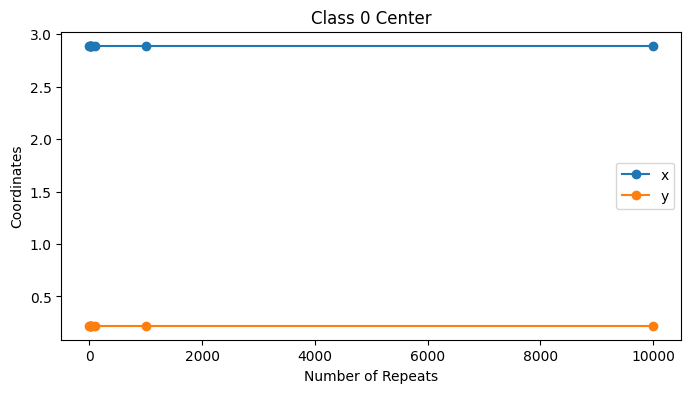

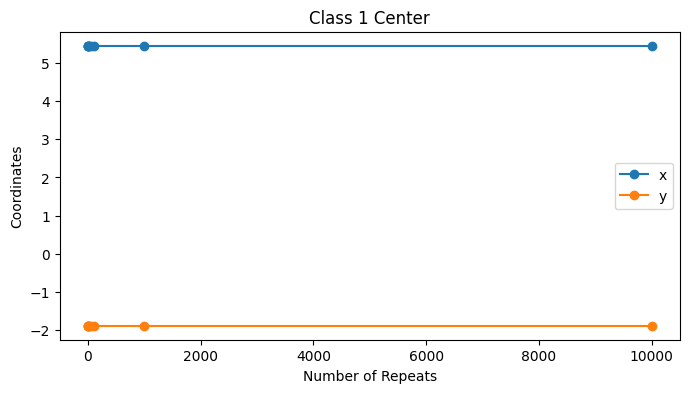

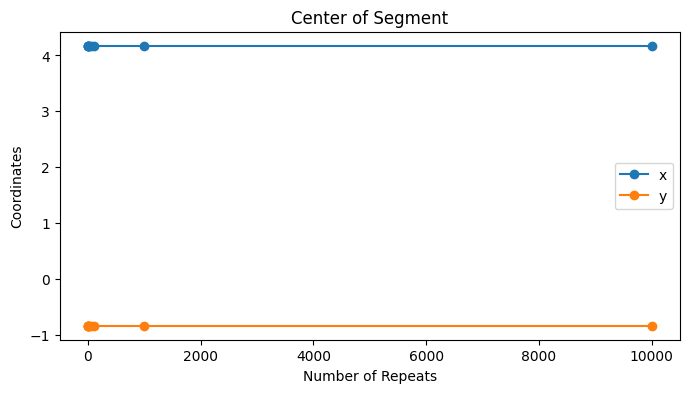

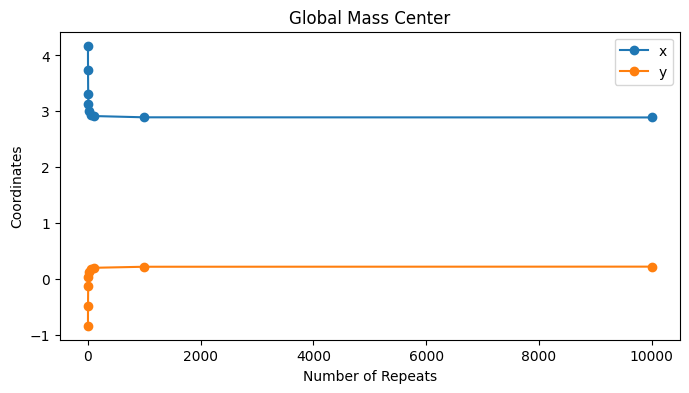

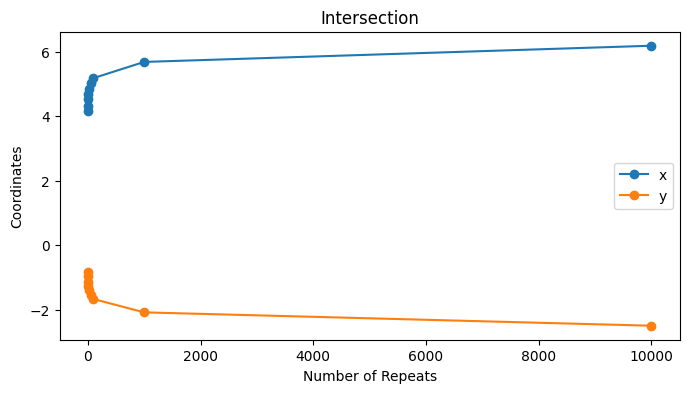

In [ ]:
titles = ['Class 0 Center', 'Class 1 Center', 'Center of Segment', 'Global Mass Center', 'Intersection']

coordinates = []
coordinates += [[class_centers[i][0] for i in df_multipliers]]
coordinates += [[class_centers[i][1] for i in df_multipliers]]
coordinates += [[segment_centers[i] for i in df_multipliers]]
coordinates += [[global_centers[i] for i in df_multipliers]]
coordinates += [[intersections[i] for i in df_multipliers]]

for t in range(len(coordinates)):
    plt.figure(figsize=(8, 4))
    plt.plot(df_multipliers, [i[0] for i in coordinates[t]], label='x', marker='o')
    plt.plot(df_multipliers, [i[1] for i in coordinates[t]], label='y', marker='o')
    plt.title(f'{titles[t]}')
    plt.xlabel('Number of Repeats')
    plt.ylabel('Coordinates')
    plt.legend()
    plt.show()

[7] Выбрать целевой класс для решений из пункта [4].

Для каждого из решений из пункта [4]:
- Построить ROC кривую и рассчитать метрику AUROC.
- Построить PR кривую и рассчитать метрику AUPRC.
- (*) Построить PRgain кривую и рассчитать метрику AUPRgainC.

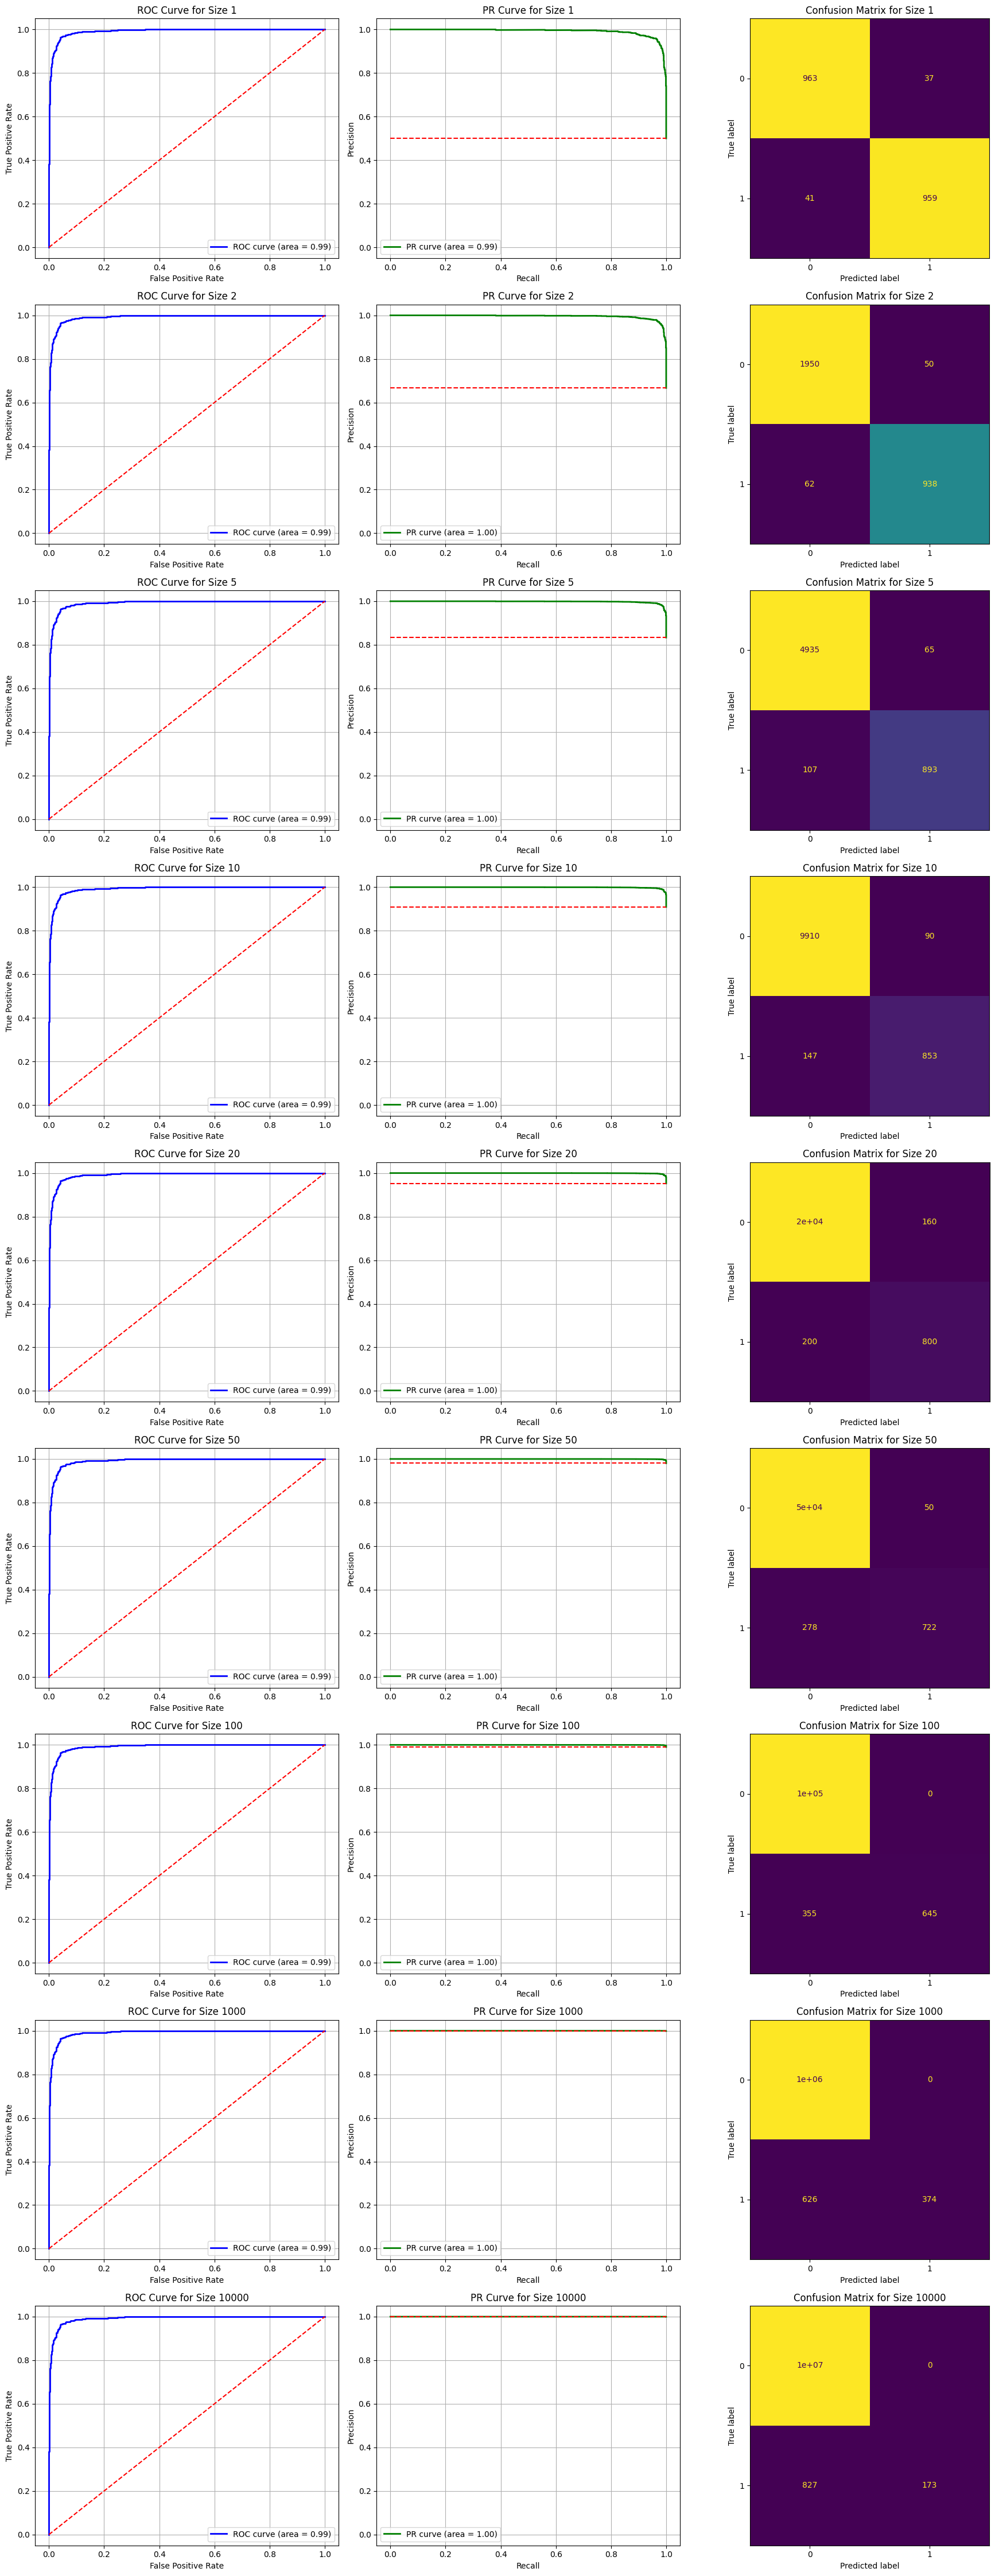

In [ ]:
fig, axes = plt.subplots(len(df_multipliers), 3, figsize=(18, 5 * len(df_multipliers)))
axes = axes.flatten()

results_7 = []

def roc_prc(df, lda, target_class, m, i):
    filtered_df = extract_classes(df)

    x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
    y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])

    class_index = 1 if target_class == 2 else 0
    y_scores = lda.predict_proba(x)[:, class_index]
    y_pred = lda.predict(x)

    fpr, tpr, _ = roc_curve(y, y_scores, pos_label=target_class)
    roc_auc = auc(fpr, tpr)

    axes[i * 3].plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc), linewidth=2)
    axes[i * 3].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[i * 3].set_xlabel('False Positive Rate')
    axes[i * 3].set_ylabel('True Positive Rate')
    axes[i * 3].set_title(f'ROC Curve for Size {m}')
    axes[i * 3].legend(loc='lower right')
    axes[i * 3].grid()

    precision, recall, _ = precision_recall_curve(y, y_scores, pos_label=target_class)
    auprc = auc(recall, precision)
    baseline = 1/(1 + m) if class_index else 1 - (1/(1 + m))

    axes[i * 3 + 1].plot(recall, precision, color='green', label='PR curve (area = {:.2f})'.format(auprc), linewidth=2)
    axes[i * 3 + 1].plot([0, 1], [baseline, baseline], color='red', linestyle='--')
    axes[i * 3 + 1].set_ylim(-0.05, 1.05)
    axes[i * 3 + 1].set_xlabel('Recall')
    axes[i * 3 + 1].set_ylabel('Precision')
    axes[i * 3 + 1].set_title(f'PR Curve for Size {m}')
    axes[i * 3 + 1].legend(loc='lower left')
    axes[i * 3 + 1].grid()

    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i * 3 + 2], colorbar=False)
    axes[i * 3 + 2].set_title(f'Confusion Matrix for Size {m}')

    results_7.append({'size': m, 'AUROC': roc_auc, 'AUPRC': auprc})

k = 0
for m in df_multipliers:
    roc_prc(repeat_df_dict[m], lda_trained[m], 0, m, k)
    k += 1

plt.tight_layout()
plt.show()

[8] В пункте [7] выбрать другой целевой класс.
- Построить ROC кривую и рассчитать метрику AUROC.
- Построить PR кривую и рассчитать метрику AUPRC.
- (*) Построить PRgain кривую и рассчитать метрику AUPRgainC.

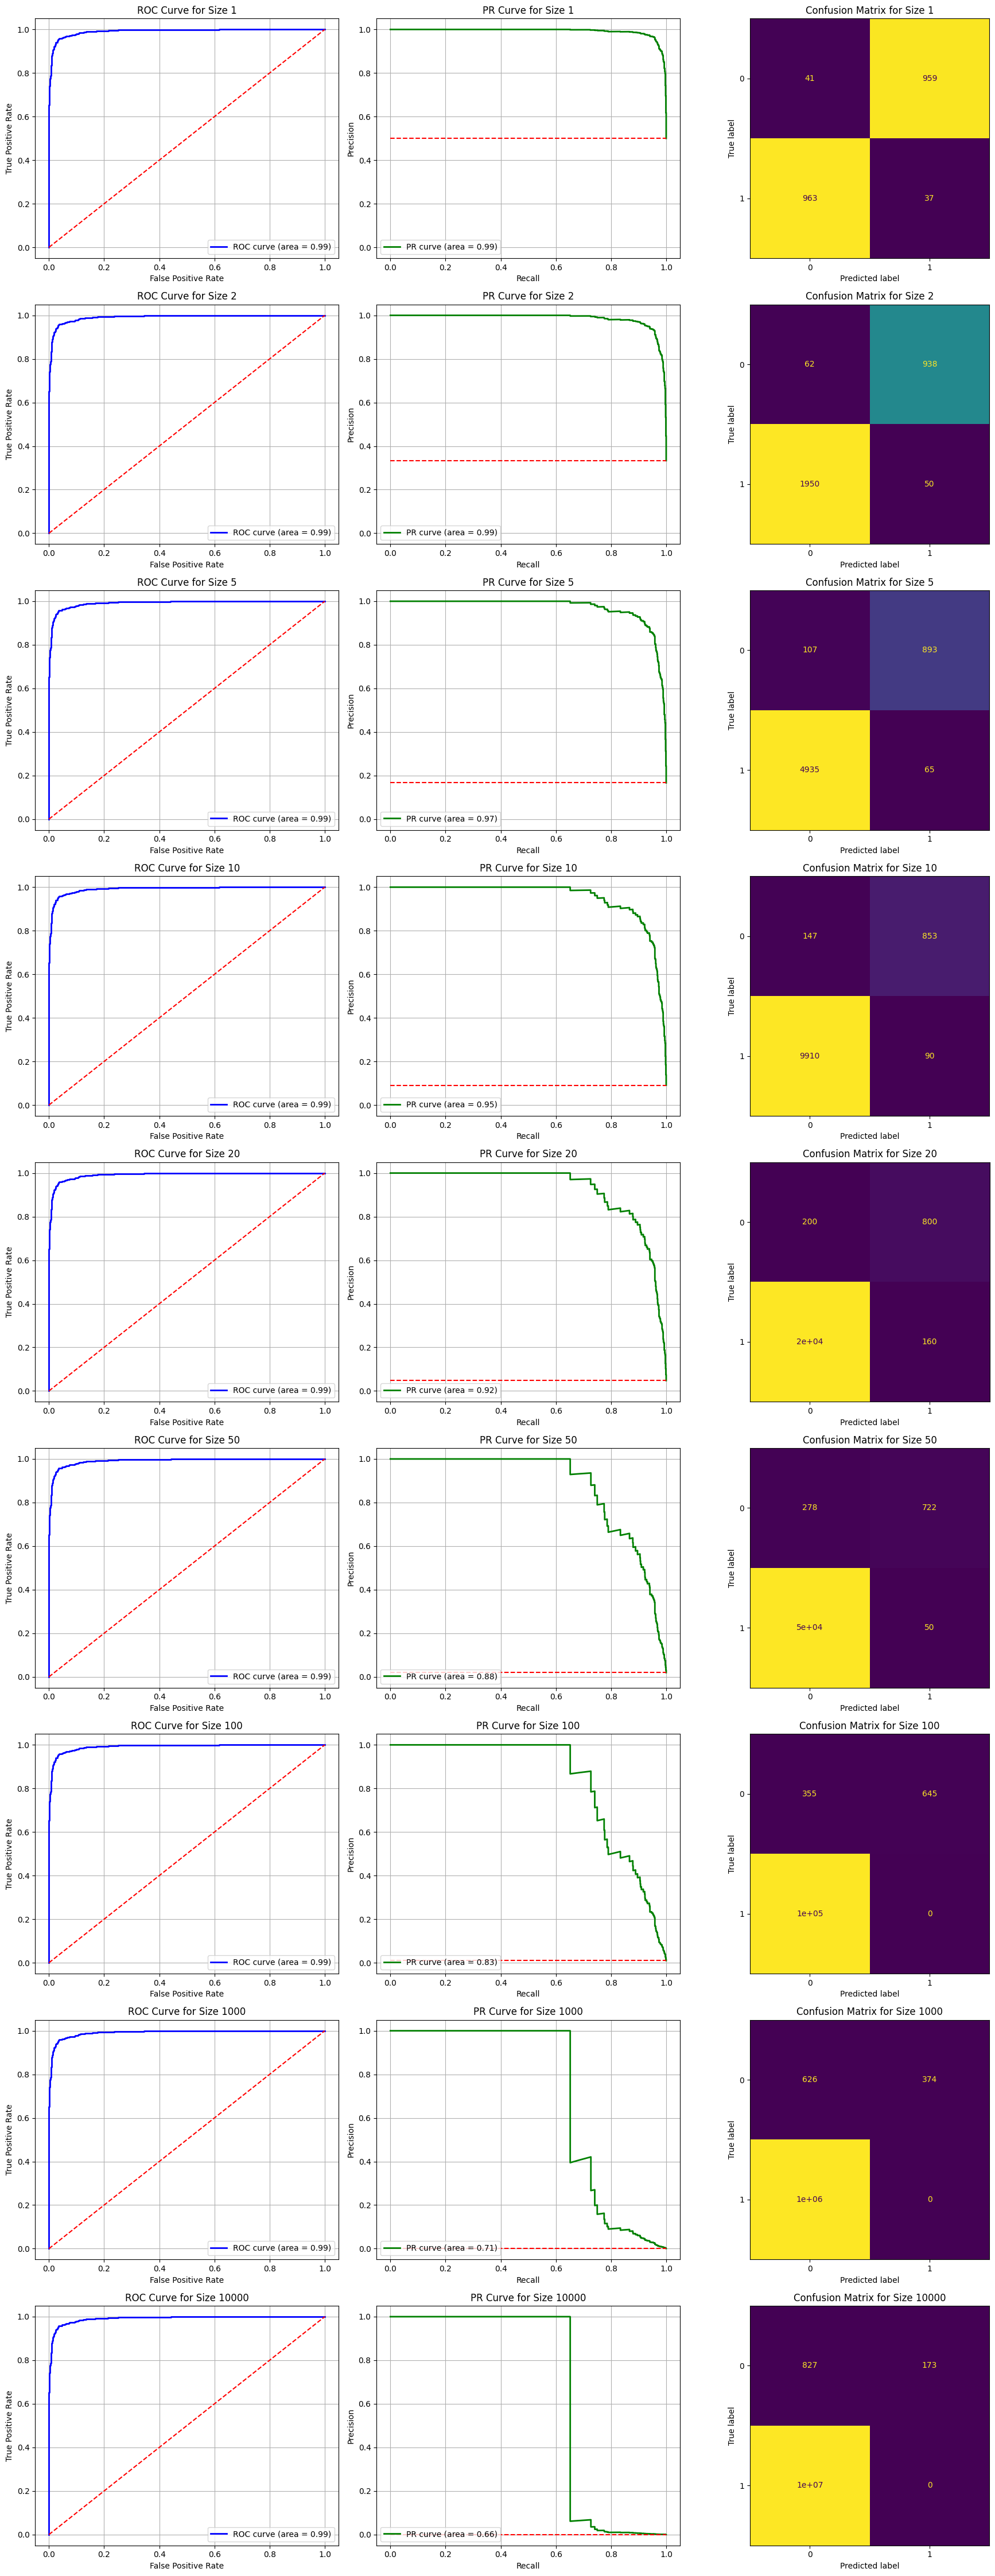

In [ ]:
fig, axes = plt.subplots(len(df_multipliers), 3, figsize=(18, 5 * len(df_multipliers)))
axes = axes.flatten()

k = 0
for m in df_multipliers:
    roc_prc(repeat_df_dict[m], lda_trained[m], 2, m, k)
    k += 1

plt.tight_layout()
plt.show()

[9] Для датасета 10k на основе 3-fold, 5-fold, 10-fold, 20-fold, 50-fold, 100-fold кросс-
валидации построить кривые AUROC и AUPRC c доверительными интервалами (CI95).

Вместо CI95 можно взять CI90, CI80 или другой вариант доверительного
интервала.

In [ ]:
# filtered_df = extract_classes(repeat_df_dict[10000])

# x = np.array([[t[0], t[1]] for t in filtered_df.values.tolist() if t[-1] in classes])
# y = np.array([t[-1] for t in filtered_df.values.tolist() if t[-1] in classes])

df_temp = extract_classes(repeat_df_dict[10000])
X = df_temp[[0, 2]]
y = df_temp['target']
y = y.replace(2, 1)

fold_values = [3, 5, 10, 20, 50, 100]

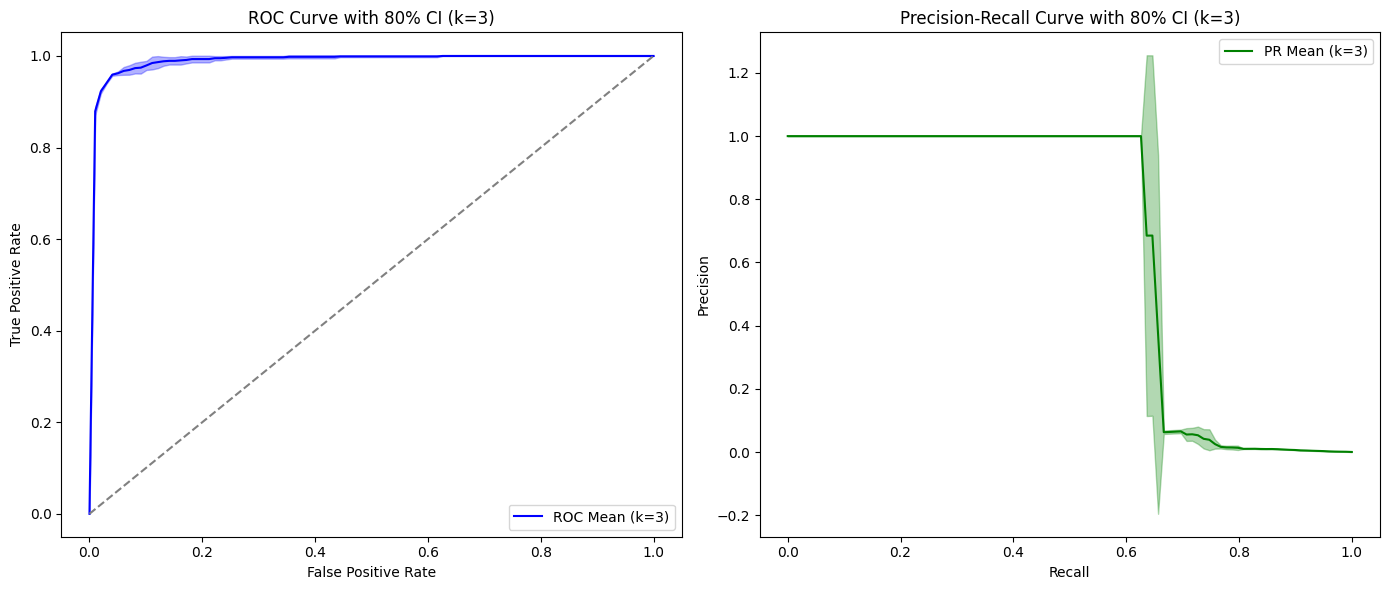

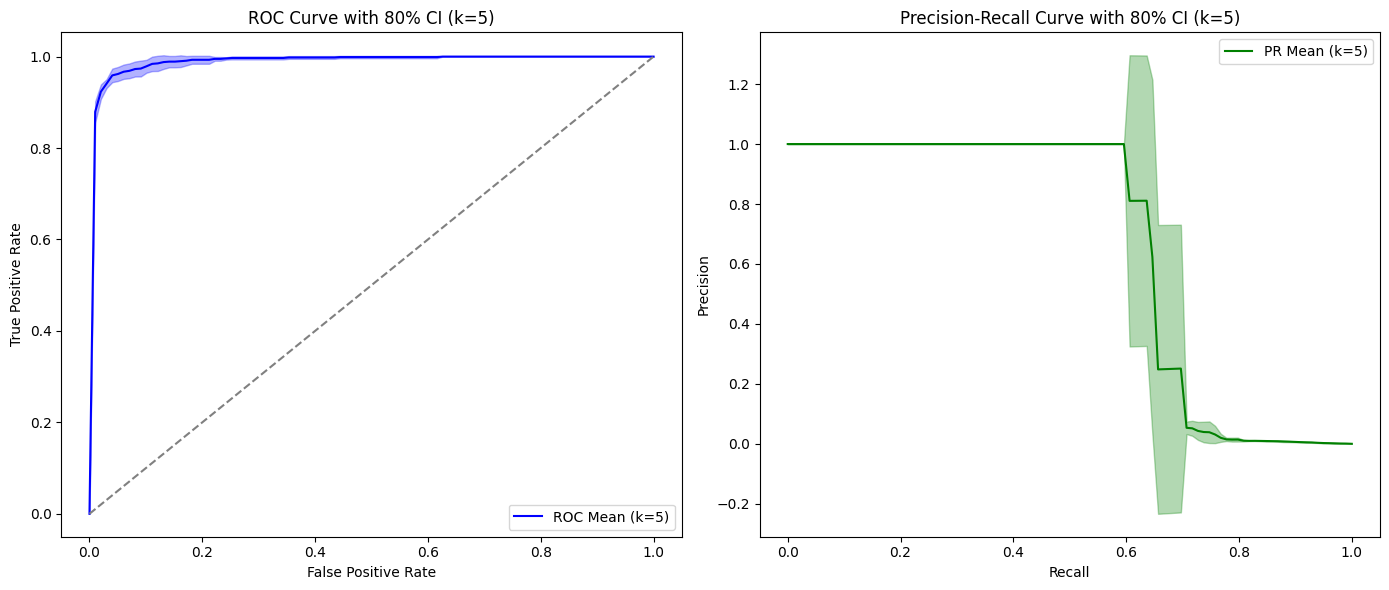

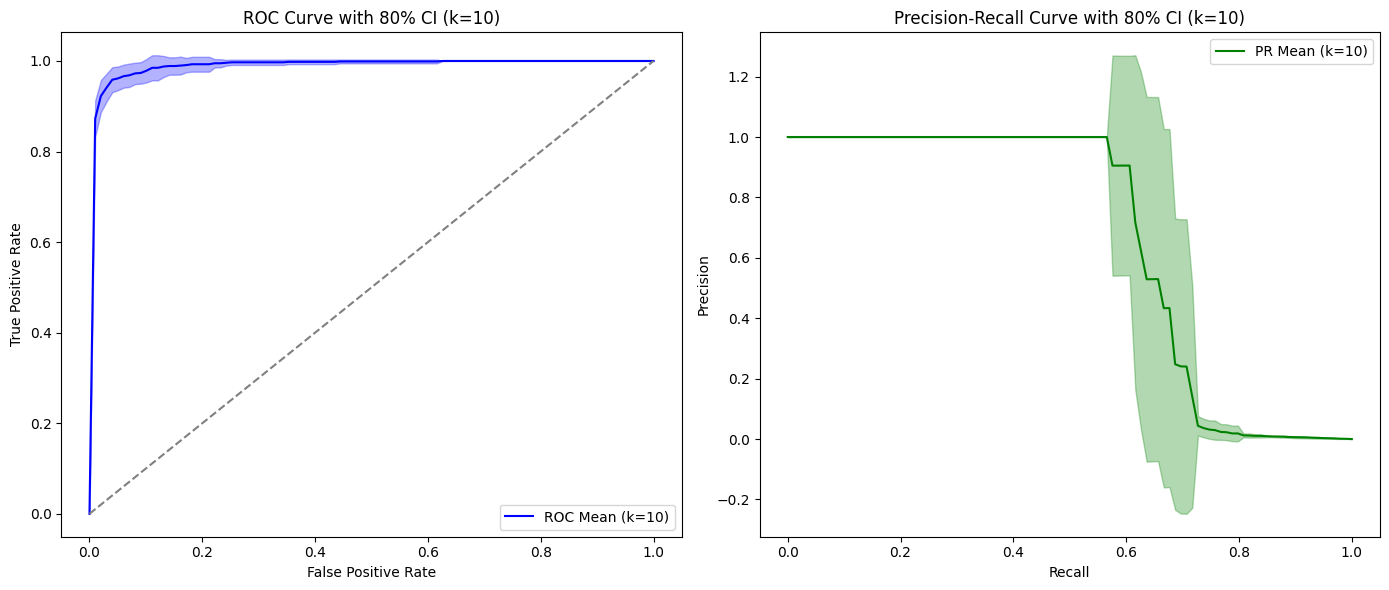

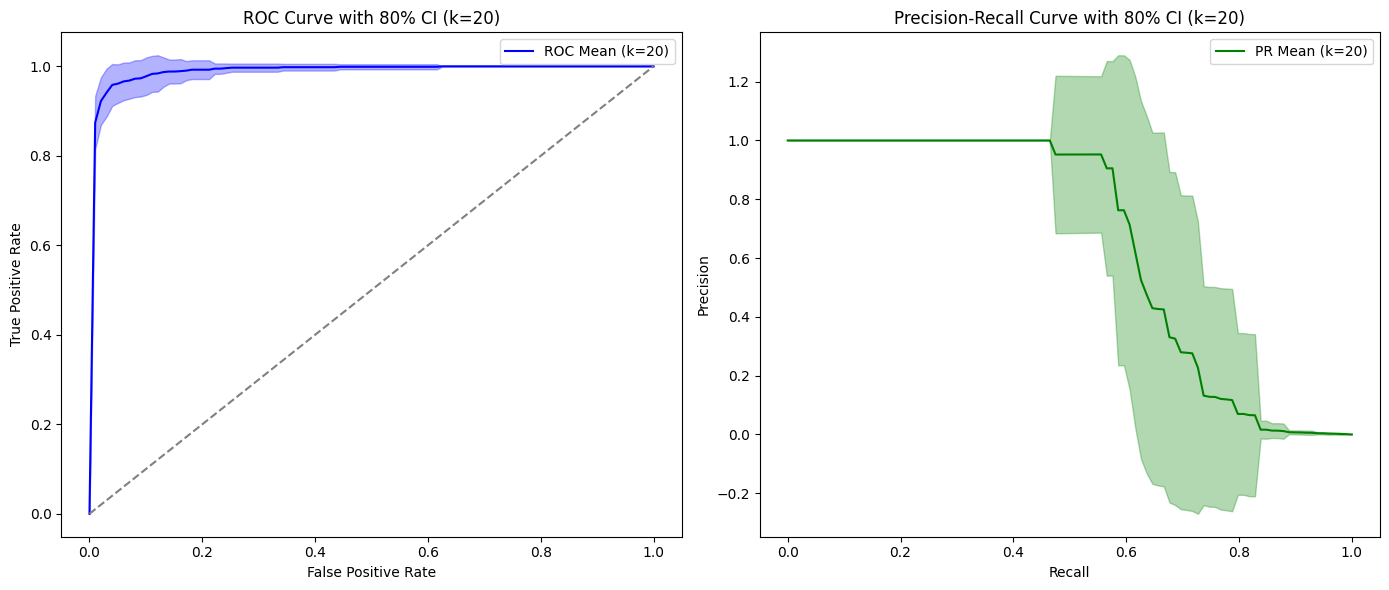

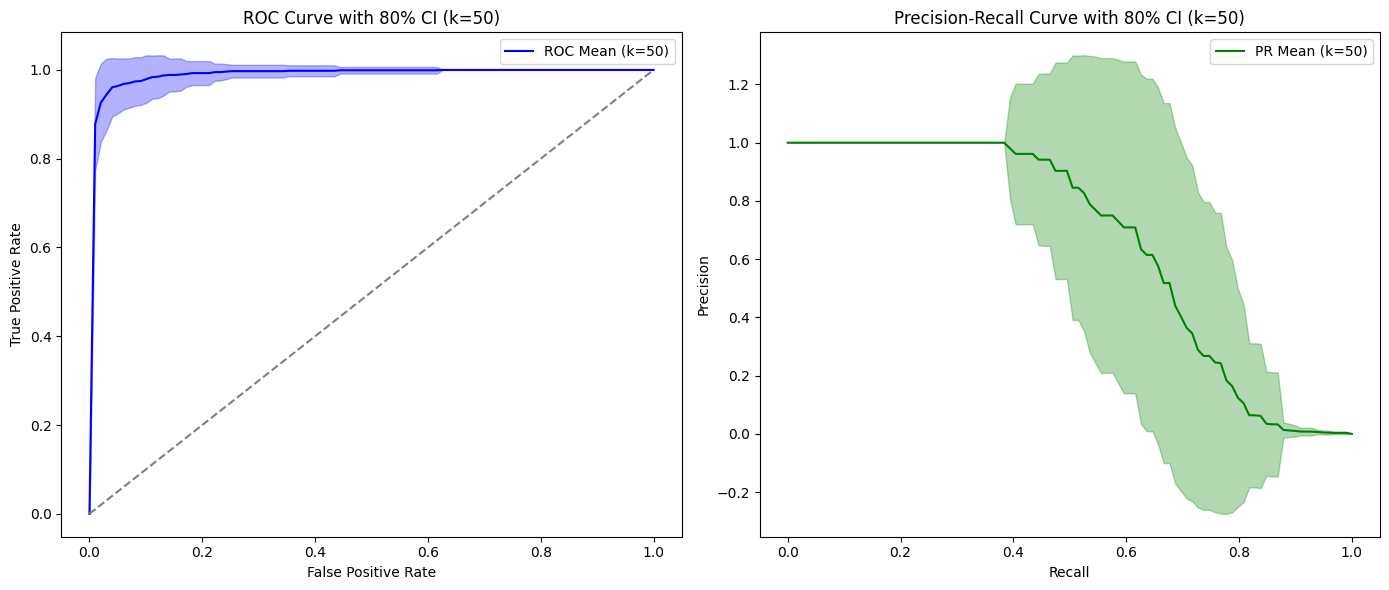

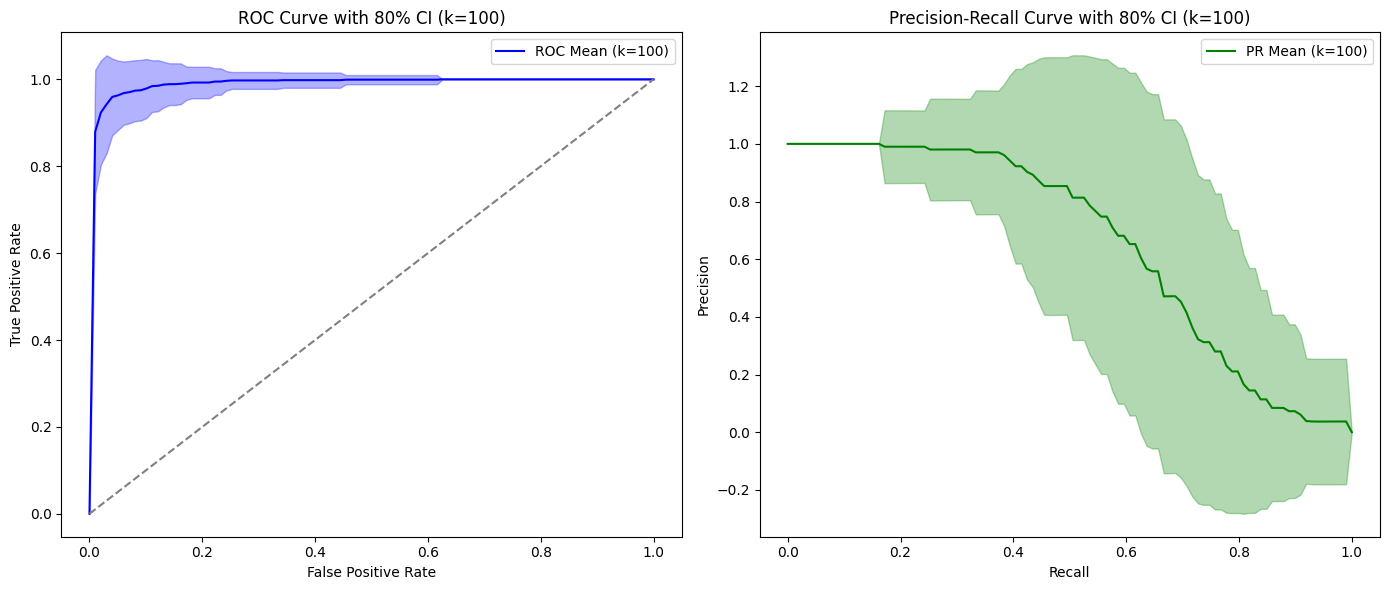

In [ ]:
def plot_confidence_interval_curve(mean_curve, std_curve, x_range, label, color, ci=95):
    ci_factor = stats.norm.ppf(1 - (1 - ci / 100) / 2)
    lower_bound = mean_curve - ci_factor * std_curve
    upper_bound = mean_curve + ci_factor * std_curve
    plt.fill_between(x_range, lower_bound, upper_bound, color=color, alpha=0.3, label=f'{label} CI {ci}%')
    plt.plot(x_range, mean_curve, color=color, label=f'{label} Mean')

def compute_roc_pr_curves(X, y, kf):
    tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    prs = []
    mean_recall = np.linspace(0, 1, 100)

    roc_aucs = []
    pr_aucs = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = LDA(n_components=1)
        model.fit(X_train, y_train)

        y_pred_proba = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        roc_aucs.append(roc_auc)

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        prs.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
        pr_auc = average_precision_score(y_test, y_pred_proba)
        pr_aucs.append(pr_auc)

    return np.array(tprs), np.array(prs), mean_fpr, mean_recall, np.array(roc_aucs), np.array(pr_aucs)

def plot_roc_pr_curves_with_ci(X, y, fold_values, ci=95):
    for k in fold_values:
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        tprs, prs, mean_fpr, mean_recall, roc_aucs, pr_aucs = compute_roc_pr_curves(X, y, kf)

        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        mean_tpr[-1] = 1.0
        axs[0].fill_between(mean_fpr, mean_tpr - stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_tpr,
                            mean_tpr + stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_tpr, color='blue', alpha=0.3)
        axs[0].plot(mean_fpr, mean_tpr, color='blue', label=f'ROC Mean (k={k})')
        axs[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
        axs[0].set_xlabel('False Positive Rate')
        axs[0].set_ylabel('True Positive Rate')
        axs[0].set_title(f'ROC Curve with {ci}% CI (k={k})')
        axs[0].legend()

        mean_pr = np.mean(prs, axis=0)
        std_pr = np.std(prs, axis=0)
        axs[1].fill_between(mean_recall, mean_pr - stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_pr,
                            mean_pr + stats.norm.ppf(1 - (1 - ci / 100) / 2) * std_pr, color='green', alpha=0.3)
        axs[1].plot(mean_recall, mean_pr, color='green', label=f'PR Mean (k={k})')
        axs[1].set_xlabel('Recall')
        axs[1].set_ylabel('Precision')
        axs[1].set_title(f'Precision-Recall Curve with {ci}% CI (k={k})')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

# df_temp = duplicate_class(df, cls_name=1, n=1000)
# df_temp = df_temp[df_temp['class'].isin([1, 2])]
# X = df_temp[['feature_3', 'feature_4']]
# y = df_temp['class']
# y = y.replace(1, 0)
# y = y.replace(2, 1)

df_temp = extract_classes(repeat_df_dict[10000])
x = df_temp[[0, 2]]
y = df_temp['target']
y = y.replace(2, 1)

fold_values = [3, 5, 10, 20, 50, 100]

plot_roc_pr_curves_with_ci(x, y, fold_values, ci=80)